In [276]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [277]:
def utility_compare(Hstore, Honline, Lstore, Lonline):
    if max(Lstore, Lonline) >= 0 and max(Hstore, Honline) >= 0:
        if Lstore > Lonline:
            return "BS"
        else:
            return "BO"

    elif max(Lstore, Lonline) >= 0 and max(Hstore, Honline) < 0:
        if Lstore > Lonline:
            return "LS"
        else:
            return "LO"

    elif max(Lstore, Lonline) < 0 and max(Hstore, Honline) >= 0:
        if Hstore > Honline:
            return "HS"
        else:
            return "HO"

    elif max(Lstore, Lonline) < 0 and max(Hstore, Honline) < 0:
        return "No sales"
    else:
        raise Exception("other cases")

class NumSolver:
    def __init__(self, V=0.8, GAMMA=0.2, P_HAT=0.1, DELTA_h=0.6, DELTA_l=0.2, CR=0.7):
        self.V = V
        self.GAMMA = GAMMA
        self.P_HAT = P_HAT
        self.DELTA_h = DELTA_h
        self.DELTA_l = DELTA_l
        self.CR = CR

    def get_utility(self, TYPE, p, poff, c, con):

        if p >= self.P_HAT:
            delta = self.DELTA_h
        else:
            delta = self.DELTA_l

        if TYPE == "H":
            theta = 1.00
        elif TYPE == "L":
            theta = self.V
        else:
            raise Exception("Consumer Type Error!")
        u_store = (theta - poff) / 2 - c
        u_online = (theta - 2 * p + delta * p) / 2 - con
        # return np.round(u_store, 3), np.round(u_online, 3)

        # quicker round
        u_store = int(u_store * 1000000 + 0.5) / 1000000
        u_online = int(u_online * 1000000 + 0.5) / 1000000
        return u_store, u_online

    def get_profit(self, p, poff, c, con, logger=False):

        if p >= self.P_HAT:
            delta = self.DELTA_h
        else:
            delta = self.DELTA_l

        H_u_store, H_u_online = self.get_utility("H", p, poff, c, con)
        L_u_store, L_u_online = self.get_utility("L", p, poff, c, con)

        if logger:
            if max(L_u_store, L_u_online) >= 0 and max(H_u_store, H_u_online) >= 0:
                if L_u_store > L_u_online:
                    print("sell to both H and L segments offline")
                else:
                    print("sell to both H and L segments online")

            elif max(L_u_store, L_u_online) >= 0 and max(H_u_store, H_u_online) < 0:
                if L_u_store > L_u_online:
                    print("sell to L segment offline")
                else:
                    print("sell to L segment online")

            elif max(L_u_store, L_u_online) < 0 and max(H_u_store, H_u_online) >= 0:
                if H_u_store > H_u_online:
                    print("sell to H segment offline")
                else:
                    print("sell to H segment online")

            elif max(L_u_store, L_u_online) < 0 and max(H_u_store, H_u_online) < 0:
                print("No sales")
            else:
                raise Exception("other cases")

        pi_H_online = 1 / 4 * self.GAMMA * (2 * p - delta * (p + self.CR)) * (
            [1 if (H_u_online >= 0 and H_u_online >= H_u_store) else 0][0])
        pi_H_store = 1 / 4 * self.GAMMA * poff * ([1 if (H_u_store >= 0 and H_u_online < H_u_store) else 0][0])

        pi_L_online = 1 / 4 * (1 - self.GAMMA) * (2 * p - delta * (p + self.CR)) * (
            [1 if (L_u_online >= 0 and L_u_online >= L_u_store) else 0][0])
        pi_L_store = 1 / 4 * (1 - self.GAMMA) * poff * ([1 if (L_u_store >= 0 and L_u_online < L_u_store) else 0][0])

        expected_profit = pi_H_online + pi_H_store + pi_L_online + pi_L_store

        return expected_profit


In [278]:


class Run():

    def __init__(self,HighReturnProb, LowReturnProb, PriceThreshold,
                 ValLow, PropHigh, OnlineCost, ReturnCostRet,logger=True):

        self.HighReturnProb = HighReturnProb

        self.LowReturnProb = LowReturnProb

        self.PriceThreshold = PriceThreshold

        self.ValLow = ValLow

        self.PropHigh = PropHigh
        
        self.OnlineCost = OnlineCost

        self.ReturnCostRet = ReturnCostRet
        
        self.logger = logger
        
        self.res_dict={}
        
        self.read_params()
        

    def plot_figures(self, V, gamma, P_HAT, DELTA_h, DELTA_l, CR, con):
        self.solver = NumSolver(V, gamma, P_HAT, DELTA_h, DELTA_l, CR)

        optimal_profits_u = []
        optimal_prices_u = []

        optimal_profits_d = []
        optimal_prices_d = []

        behavior_tuples = []

        for current_c in np.arange(0, 1, 0.01):
            optimal_profit_u = 0
            optimal_price_u = 0
            optimal_profit_d = 0
            optimal_price_d = 0

            for p_current in np.arange(0, 1, 0.005):
                profit_current_u = self.solver.get_profit(p=p_current, poff=p_current, c=current_c, con=con)
                if profit_current_u > optimal_profit_u:
                    optimal_profit_u = profit_current_u
                    optimal_price_u = p_current

                profit_current_d = self.solver.get_profit(p=p_current, poff=p_current + con, c=current_c, con=con)
                if profit_current_d > optimal_profit_d:
                    optimal_profit_d = profit_current_d
                    optimal_price_d = p_current

            behavior_tuple = self.analyze_behavior(current_c, con, optimal_price_u,
                                                   optimal_price_d, optimal_price_d + con)

            optimal_profits_u.append(optimal_profit_u)
            optimal_prices_u.append(optimal_price_u)
            optimal_profits_d.append(optimal_profit_d)
            optimal_prices_d.append(optimal_price_d)
            behavior_tuples.append(behavior_tuple)
        if self.logger:
            for current_c, price_u, price_d, profit_u, profit_d in zip(
                    np.arange(0, 1, 0.01), optimal_prices_u, optimal_prices_d, optimal_profits_u, optimal_profits_d):
                behavior_uniform, behavior_dual = self.analyze_behavior(current_c, con, price_u,
                                                                        price_d, price_d + con)
                print("current c: {:.5f}, price_u: {:.5f}, price_d: {:.5f}".format(current_c, price_u, price_d))
                print("profit_u: {:.5f}, profit_d: {:.5f}".format(profit_u, profit_d))
                print("behavior u:{}, d:{}".format(behavior_uniform, behavior_dual))
        
        res_dict = {"profit_u": optimal_profits_u, "profit_d": optimal_profits_d,
                    "price_u": optimal_prices_u, "price_d": optimal_prices_d,
                    "behavior": behavior_tuples}
        
       
        self.res_dict = res_dict

    def read_params(self):
        delta_h = float(self.HighReturnProb)
        delta_l = float(self.LowReturnProb)
        phat = float(self.PriceThreshold)
        V = float(self.ValLow)
        gamma = float(self.PropHigh)

        con = float(self.OnlineCost)
        cr = float(self.ReturnCostRet)

        data = self.plot_figures(V=V, gamma=gamma, P_HAT=phat, DELTA_h=delta_h, DELTA_l=delta_l, CR=cr, con=con)


    def analyze_behavior(self, c, con, uniform_price, dual_online_price, dual_offline_price):
        H_u_store, H_u_online = self.solver.get_utility("H", uniform_price, uniform_price, c, con=con)
        L_u_store, L_u_online = self.solver.get_utility("L", uniform_price, uniform_price, c, con=con)

        H_d_store, H_d_online = self.solver.get_utility("H", dual_online_price, dual_offline_price, c, con=con)
        L_d_store, L_d_online = self.solver.get_utility("L", dual_online_price, dual_offline_price, c, con=con)

        behavior_uniform = utility_compare(H_u_store, H_u_online, L_u_store, L_u_online)
        behavior_dual = utility_compare(H_d_store, H_d_online, L_d_store, L_d_online)
        return behavior_uniform, behavior_dual

In [284]:
def show_result(solver):
    min_c_ind = list( np.arange(0, 0.35, 0.01)).index(solver.OnlineCost)
    max_c_ind = list( np.arange(0, 0.35, 0.01)).index(0.3)
    sel_c = np.arange(0, 0.35, 0.01)[min_c_ind:max_c_ind]
    sel_prices_u = solver.res_dict["price_u"][min_c_ind:max_c_ind]
    sel_prices_d = solver.res_dict["price_d"][min_c_ind:max_c_ind]
    sel_profits_u = solver.res_dict["profit_u"][min_c_ind:max_c_ind]
    sel_profits_d = solver.res_dict["profit_d"][min_c_ind:max_c_ind]
    fig = plt.figure(figsize=(10,4))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(sel_c, sel_profits_u,c='red', ls='--', ms=6, marker='*', label="Uniform")
    ax1.plot(sel_c, sel_profits_d,c='blue', ls='--', ms=6, marker='o',label="Dual")

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(sel_c, sel_prices_u,c='red', ls='--', ms=6, marker='*',label="Uniform")
    ax2.plot(sel_c, sel_prices_d, c='blue', ls='--', ms=6, marker='o', label="Online of Dual")
    ax2.plot(sel_c, [x + solver.OnlineCost for x in sel_prices_d], c='green', ls='--', ms=6, marker='D',
             label="Offline of Dual")


    ax1.legend(prop=dict(size=9), frameon=False)
    ax1.set_ylabel("Profits", fontsize =16)
    ax1.set_xlabel("c", fontsize =16)
    
    ax2.legend(prop=dict(size=9), frameon=False)
    ax2.set_ylabel("Prices", fontsize =16)
    ax2.set_xlabel("c", fontsize =16)
    plt.tight_layout()
    plt.show()
    
    return 


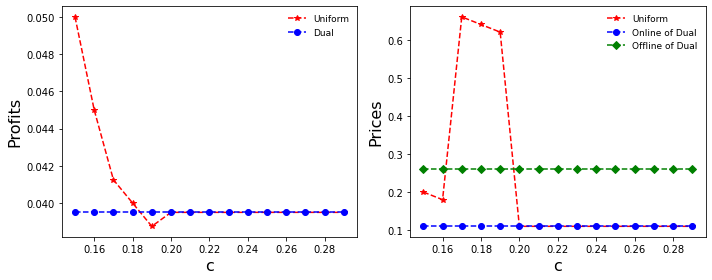

In [285]:
show_result(Run(HighReturnProb=0.8, LowReturnProb=0.2, PriceThreshold=0.3,
                 ValLow=0.5, PropHigh=0.25, OnlineCost=0.15, ReturnCostRet=0.2,logger=False))

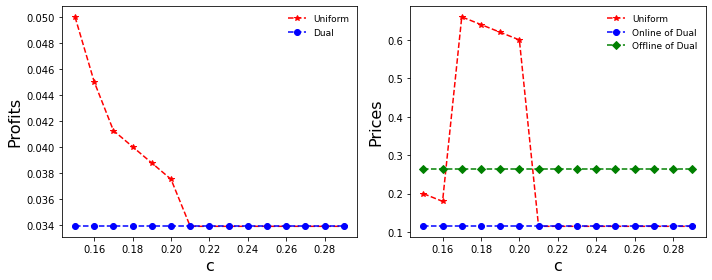

In [286]:
show_result(Run(HighReturnProb=0.8, LowReturnProb=0.3, PriceThreshold=0.3,
                 ValLow=0.5, PropHigh=0.25, OnlineCost=0.15, ReturnCostRet=0.2,logger=False))

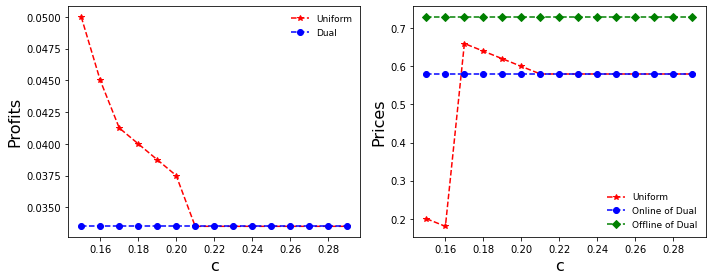

In [287]:
show_result(Run(HighReturnProb=0.8, LowReturnProb=0.4, PriceThreshold=0.3,
                 ValLow=0.5, PropHigh=0.25, OnlineCost=0.15, ReturnCostRet=0.2,logger=False))

In [269]:
def figure_merge(LowReturnProbs, fz=(20,8)):
    solvers = []
    for lrp in LowReturnProbs:
        solvers.append(Run(HighReturnProb=0.8, LowReturnProb=lrp, PriceThreshold=0.3,
                 ValLow=0.5, PropHigh=0.25, OnlineCost=0.15, ReturnCostRet=0.2,logger=False))
        
    
    fig,axes = plt.subplots(2, len(LowReturnProbs),sharex='col', sharey='row',figsize=fz)
    fig.subplots_adjust(hspace=0.6, wspace=0.4)
    
    for j in range(len(LowReturnProbs)):
        min_c_ind = list( np.arange(0, 0.35, 0.01)).index(solvers[j].OnlineCost)
        max_c_ind = list( np.arange(0, 0.35, 0.01)).index(0.3)
        sel_c = np.arange(0, 0.35, 0.01)[min_c_ind:max_c_ind]
        
        sel_prices_u = solvers[j].res_dict["price_u"][min_c_ind:max_c_ind]
        sel_prices_d = solvers[j].res_dict["price_d"][min_c_ind:max_c_ind]

        axes[0,j].plot(sel_c, sel_prices_u,c='red', ls='--', ms=6, marker='^', markerfacecolor='none',label="Uniform")
        axes[0,j].plot(sel_c, sel_prices_d, c='blue', ls='--', ms=6, marker='o',  markerfacecolor='none',label="Online of Dual")
        axes[0,j].plot(sel_c, [x + solvers[j].OnlineCost for x in sel_prices_d], c='green', ls='--', ms=6, marker='D',
                 markerfacecolor='none',label="Offline of Dual")

        axes[0,j].legend(prop=dict(size=12), frameon=False)
        
        #axes[0,j].set_xlabel("c", fontsize =16)
        
        axes[0,j].set_title(r"$\delta_L$={} ".format(LowReturnProbs[j]), fontsize=20)
        
        sel_profits_u = solvers[j].res_dict["profit_u"][min_c_ind:max_c_ind]
        sel_profits_d = solvers[j].res_dict["profit_d"][min_c_ind:max_c_ind]
        
        axes[1,j].plot(sel_c, sel_profits_u,c='red', ls='--', ms=6, marker='^', markerfacecolor='none', label="Uniform")
        axes[1,j].plot(sel_c, sel_profits_d,c='blue', ls='--', ms=6, marker='o',markerfacecolor='none',label="Dual")

        axes[1,j].legend(prop=dict(size=12), frameon=False)
        # axes[1,j].set_xlabel("c", fontsize =16)
        
    axes[0,0].set_ylabel("Prices", fontsize =16)
    axes[1,0].set_ylabel("Profits", fontsize =16)
    fig.text(0.5, 0, 'c', ha='center',fontsize =20)
    fig.tight_layout()
    return fig

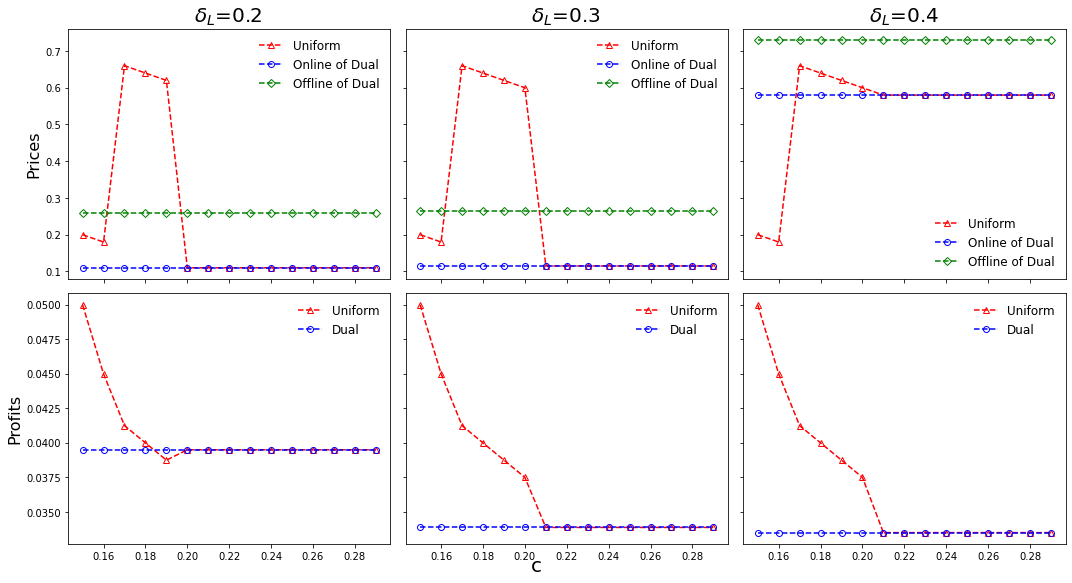

In [270]:
myfig = figure_merge([0.2,0.3,0.4], fz = (5*3, 8))

In [271]:
myfig.savefig("./PRICE_RELATED_RETRURN.pdf")